In [ ]:
### Functions for Analysis ###
import pymesh
import numpy as np
import sys
import pyflann
from Bio.PDB import PDBParser, Selection
import os
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family':'DejaVu Sans',
    'font.sans-serif':['DejaVu Sans',],
    'axes.labelsize':8,
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'figure.dpi': 200
    })

sys.path.append("../source/")
root_dir = os.getcwd()


In [21]:
# for benchmark comparison
ground_truth_dir = f'{root_dir}/ground_truth/'
structure_dir = f'{root_dir}/struct_pdb/'
benchmark_file = f'{root_dir}/benchmark.txt'

# List of masif_pmp_predictions
masif_pred_dir = f'{root_dir}/masif-pmp_pred/convl3/'

# List of pmipred_predictions
pmipred_pred_dir = f'{root_dir}/pmipred_pred/'

# List of dreamm_predictions
dreamm_pred_dir = f'{root_dir}/dreamm_pred/'

# List of ppm_predictions
ppm_pred_dir = f'{root_dir}/ppm_pred/'


In [22]:
# The list that we will use has 21 proteins which are the ones that worked on PMIpred benchmark.
benchmark_pdbs = set([''.join(x[0:4]) for x in open(benchmark_file).readlines()])

In [4]:
# To follow SPPIDER's implementation  we only label as interface those residues
# with points with more than 4% RSA change and at least 5A RSA change.
def is_res_iface(res_labels, vertex_areas):
    sum_iface_area = 0.0
    sum_total_res_area = 0.0

    for ix, label in enumerate(res_labels): 
        sum_total_res_area += vertex_areas[ix]
        if label > 0:
            sum_iface_area += vertex_areas[ix]

    if sum_iface_area > 5.0 and sum_iface_area/sum_total_res_area > 0.04:
        return True
    else:
        return False


In [5]:
# Get the ground truth per residue (as we have it per surface point.)
# Atoms: list of PDB atoms in Biopython format. 
# Residues: list of PDB residues in Biopython format. 
# ground_truth_mesh: a pymesh mesh object with labeled interface (the ground truth.)
# Returns a dict where the key is the residue id and the value is the score. 
def assign_labels_per_residue(atoms, residues, ground_truth_mesh):
    # For every residue, assign a label on whether it is interface or not, based on the buried surface.
    flann = pyflann.FLANN()
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    verts = ground_truth_mesh.vertices.astype(float)

    labels = ground_truth_mesh.get_attribute('vertex_iface')
    ground_truth_mesh.add_attribute("vertex_area")
    vertex_areas = ground_truth_mesh.get_attribute("vertex_area")

    # Compute the closest atom to each vertex. 
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n = len(r)
    
    # For each residue, assign the ground truth based on the closest atom. 
    res_labels = {}
    res_areas = {}
    for ix, v in enumerate(verts): 
        pred = labels[ix]
        res_id = atoms[r[ix]].get_parent().get_id()
        if res_id not in res_labels:
            res_labels[res_id] = []
            res_areas[res_id] = []
        res_labels[res_id].append(pred)
        res_areas[res_id].append(vertex_areas[ix])
    res_labels_tmp = []
    for key in res_labels:
        # To follow SPPIDER's implementation (as an approximation) we only label as interface those residues 
        # with points with more than 4% RSA change and at least 5A RSA change.
        if is_res_iface(res_labels[key], res_areas[key]):
            res_labels[key] = 1.0
        else:
            res_labels[key] = 0.0
    return res_labels

In [6]:
# Compute the MASIF-PMP predictions per residue.
# Params: myid: PDBID_CHAIN format
# scores: the predicted scores for this one. 
def compute_pred_labels_per_residue(structure_dir, myid, scores):
    # We use the same pdb that PMIpred predicted. 
    parser = PDBParser(QUIET=True)
    # Use the same pdb that PMIpred used.
    struct = parser.get_structure(structure_dir+myid+'.pdb',structure_dir+myid+'.pdb')
    atoms = Selection.unfold_entities(struct, 'A')
    residues = Selection.unfold_entities(struct, 'R')
    
    ground_truth_mesh = pymesh.load_mesh(ground_truth_dir+myid+'.ply')
    
    res_labels = assign_labels_per_residue(atoms, residues, ground_truth_mesh)
    
    # Now assign predictions to each vert    
    verts = ground_truth_mesh.vertices
    ground_truth_mesh.add_attribute("vertex_area")
    vertex_areas = ground_truth_mesh.get_attribute("vertex_area")
    
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    verts = ground_truth_mesh.vertices.astype(float)
    
    
    residues = [x for x in verts]
    flann = pyflann.FLANN()
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each residue, assign the max score. 
    res_scores = {}
    res_areas = {}
    for ix, v in enumerate(verts): 
        pred = scores[ix]
        res_id = atoms[r[ix]].get_parent().get_id()
        if res_id not in res_scores:
            res_scores[res_id] = []
            res_areas[res_id] = []
        res_scores[res_id].append(pred)
        res_areas[res_id].append(pred)
    print('Total number of residues {}'.format(len(res_scores.keys())))

    for key in res_scores:
        res_scores[key] =  np.max(res_scores[key])  

    pred_per_res = []
    labels_per_res = []
    for key in res_labels: 
        if key in res_scores and key in res_labels:
            pred_per_res.append(res_scores[key])
            labels_per_res.append(res_labels[key])

    
    return pred_per_res, labels_per_res 

In [7]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve

# Compute the best threshold for MASIF-PMP predictions using Matthews Correlation Coefficient (MCC).
def compute_mcc(y_true, y_scores):
    prec, rec, thresholds = precision_recall_curve(y_true, y_scores)

    mcc_values = []
    for t in thresholds:
        preds = (y_scores >= t).astype(int)
        mcc_values.append(matthews_corrcoef(y_true, preds))

    best_idx = max(range(len(mcc_values)), key=lambda i: mcc_values[i])
    best_threshold = thresholds[best_idx]
    best_mcc = mcc_values[best_idx]

    return best_mcc, best_threshold

# Compute per residue and per point ROC AUC scores for MASIF-PMP
def compute_scores_auc(pred_dir):
    all_my_scores = []
    all_my_labels = []
    all_my_auc_per_protein = {}
    all_my_auc_per_res = []
    all_my_names = []
    
    all_my_pred_per_res = []
    all_my_labels_per_res = []
    count = 0

    for name in os.listdir(pred_dir): 

        myid = name.split('.')[0]
        pdbid = myid.split('_')[0]
        print(f'{pdbid}')
    
        if pdbid not in benchmark_pdbs: 
            continue
        # Load interface for file. 
        mesh = pymesh.load_mesh(pred_dir+'/'+name)
        mesh_pred = mesh.get_attribute('vertex_iface')
        all_my_scores.append(mesh_pred)
        
        # Load groundtruth for file. 
        mesh = pymesh.load_mesh(ground_truth_dir+'/'+name)
        groundtruth = mesh.get_attribute('vertex_iface')
        all_my_labels.append(groundtruth)
        
        auc = metrics.roc_auc_score(groundtruth, mesh_pred)
        all_my_auc_per_protein[myid] = auc

        count = count+1
            
        print('{} ROC AUC: {}'.format(myid, auc))
            
        # Compute the prediction per residue.
        pred_per_res, labels_per_res = compute_pred_labels_per_residue(structure_dir, myid, mesh_pred)
        print('ground truth res num: {}'.format(np.sum(labels_per_res)))

        auc_per_res = metrics.roc_auc_score(labels_per_res, pred_per_res)
        all_my_auc_per_res.append(auc_per_res)


        all_my_pred_per_res.append(pred_per_res)
        all_my_labels_per_res.append(labels_per_res)
        print('{} ROC AUC per res: {}\n'.format(myid, auc_per_res))

    all_my_scores = np.concatenate(all_my_scores, axis=0)
    all_my_labels = np.concatenate(all_my_labels, axis=0)
    print('Number of proteins: {}'.format(count))
    print('Median AUC per res: {}'.format(np.median(all_my_auc_per_res)))
            
    return all_my_scores, all_my_labels, all_my_auc_per_protein, \
                    all_my_names, \
                    all_my_labels_per_res, all_my_pred_per_res, \
                    all_my_auc_per_res


# Compute per residue and per point MCC scores for MASIF-PMP
def compute_scores_mcc(pred_dir, pred_thres=False):
    all_my_scores = []
    all_my_labels = []
    all_my_mcc_per_protein = {}
    all_my_mcc_per_res = []
    all_my_names = []
    
    all_my_pred_per_res = []
    all_my_labels_per_res = []
    thres_surf = []
    thres_res = []
    if pred_thres:
        all_my_pred_thres = []
        all_my_pred_thres_per_res = []

    count = 0

    for name in os.listdir(pred_dir): 

        myid = name.split('.')[0]
        pdbid = myid.split('_')[0]
        print(f'{pdbid}')
    
        if pdbid not in benchmark_pdbs: 
            continue
        # Load interface for file. 
        mesh = pymesh.load_mesh(pred_dir+'/'+name)
        mesh_pred = mesh.get_attribute('vertex_iface')
        all_my_scores.append(mesh_pred)
        
        # Load groundtruth for file. 
        mesh = pymesh.load_mesh(ground_truth_dir+'/'+name)
        groundtruth = mesh.get_attribute('vertex_iface')
        all_my_labels.append(groundtruth)

        mcc, threshold = compute_mcc(groundtruth, mesh_pred)
        all_my_mcc_per_protein[myid] = mcc
        thres_surf.append(threshold)
        if pred_thres:
            pred_point = (mesh_pred >= threshold).astype(int)
            all_my_pred_thres.append(pred_point)

        count = count+1

        print('{} MCC: {}'.format(myid, mcc))

        # Compute the prediction per residue.
        pred_per_res, labels_per_res = compute_pred_labels_per_residue(structure_dir, myid, mesh_pred)
        print('ground truth res num: {}'.format(np.sum(labels_per_res)))

        mcc_per_res, threshold_per_res = compute_mcc(labels_per_res, pred_per_res)
        all_my_mcc_per_res.append(mcc_per_res)
        thres_res.append(threshold_per_res)
        if pred_thres:
            pred_res = (pred_per_res >= threshold_per_res).astype(int)
            all_my_pred_thres_per_res.append(pred_res)

        all_my_pred_per_res.append(pred_per_res)
        all_my_labels_per_res.append(labels_per_res)
        print('{} MCC per res: {}\n'.format(myid, mcc_per_res))

    all_my_scores = np.concatenate(all_my_scores, axis=0)
    all_my_labels = np.concatenate(all_my_labels, axis=0)
    print('Number of proteins: {}'.format(count))
    print('Median MCC per res: {}'.format(np.median(all_my_mcc_per_res)))

    if pred_thres:
        all_my_pred_thres = np.concatenate(all_my_pred_thres, axis=0)
        all_my_pred_thres_per_res = np.concatenate(all_my_pred_thres_per_res, axis=0)
        return all_my_scores, all_my_labels, all_my_mcc_per_protein, \
                        all_my_names, \
                        all_my_labels_per_res, all_my_pred_per_res, \
                        all_my_mcc_per_res, all_my_pred_thres, all_my_pred_thres_per_res, thres_surf, thres_res
    else:
        return all_my_scores, all_my_labels, all_my_mcc_per_protein, \
                        all_my_names, \
                        all_my_labels_per_res, all_my_pred_per_res, \
                        all_my_mcc_per_res, thres_surf, thres_res

### 1. compute scores

#### 1-1. MaSIF-PMP pred

In [ ]:
from sklearn import metrics

all_scores_masif, all_labels_masif, all_auc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_auc_per_protein_per_res_masif = compute_scores_auc(masif_pred_dir)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    


### summary statistics

print('ROC AUC for all points : {:.3f}'.format(metrics.roc_auc_score(all_labels_masif, all_scores_masif)))
print('ROC AUC for all residues: {:.3f}'.format(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median AUC per protein at the residue level: {:.3f}'.format(np.median(all_auc_per_protein_per_res_masif)))

all_auc_per_protein_masif_list = [all_auc_per_protein_masif[x] for x in all_auc_per_protein_masif.keys() ]
print(np.median(all_auc_per_protein_masif_list))

print('Median AUC per protein at the point level: {:.3f}'.format(np.median(all_auc_per_protein_masif_list)))


1COY
1COY_A ROC AUC: 0.6116995292253025
Total number of residues 403
ground truth res num: 1.0
1COY_A ROC AUC per res: 0.7556109725685786

1FFJ
1FFJ_A ROC AUC: 0.8837357240073377
Total number of residues 59
ground truth res num: 27.0
1FFJ_A ROC AUC per res: 0.8078703703703703

1JSS
1JSS_A ROC AUC: 0.7857306991454183
Total number of residues 186
ground truth res num: 28.0
1JSS_A ROC AUC per res: 0.8745479204339963

1LN1
1LN1_A ROC AUC: 0.7446144581528147
Total number of residues 192
ground truth res num: 34.0
1LN1_A ROC AUC per res: 0.8507073715562175

1S6X
1S6X_A ROC AUC: 0.7292414780119698
Total number of residues 33
ground truth res num: 6.0
1S6X_A ROC AUC per res: 0.882716049382716

1TQN
1TQN_A ROC AUC: 0.8955733287960663
Total number of residues 414
ground truth res num: 27.0
1TQN_A ROC AUC per res: 0.9525313427122212

1XQ8
1XQ8_A ROC AUC: 0.5362450607704546
Total number of residues 140
ground truth res num: 44.0
1XQ8_A ROC AUC per res: 0.6347064393939394

2A1L
2A1L_A ROC AUC: 0.93

In [ ]:

all_scores_masif, all_labels_masif, all_mcc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_mcc_per_protein_per_res_masif, all_my_pred_thres, all_my_pred_thres_per_res, thres_surf, thres_res = compute_scores_mcc(masif_pred_dir, pred_thres=True)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    

### summary statistics

print('MCC for all points : {:.3f}'.format(matthews_corrcoef(all_labels_masif, all_my_pred_thres)))
print('MCC for all residues: {:.3f}'.format(matthews_corrcoef(all_my_labels_per_res_masif, all_my_pred_thres_per_res)))
print('Median MCC per protein at the residue level: {:.3f}'.format(np.median(all_mcc_per_protein_per_res_masif)))

all_mcc_per_protein_masif_list = [all_mcc_per_protein_masif[x] for x in all_mcc_per_protein_masif.keys() ]
print(np.median(all_mcc_per_protein_masif_list))

print('Median MCC per protein at the point level: {:.3f}'.format(np.median(all_mcc_per_protein_masif_list)))


1COY
1COY_A MCC: 0.05632908422409896
Total number of residues 402
ground truth res num: 1.0
1COY_A MCC per res: 0.08736380295264898

1FFJ
1FFJ_A MCC: 0.6163415962372998
Total number of residues 59
ground truth res num: 27.0
1FFJ_A MCC per res: 0.5259547057403531

1JSS
1JSS_A MCC: 0.35031441656487083
Total number of residues 186
ground truth res num: 30.0
1JSS_A MCC per res: 0.49769438829668533

1LN1
1LN1_A MCC: 0.35781812565234195
Total number of residues 193
ground truth res num: 34.0
1LN1_A MCC per res: 0.47730740691859447

1S6X
1S6X_A MCC: 0.2994160807227395
Total number of residues 33
ground truth res num: 6.0
1S6X_A MCC per res: 0.65

1TQN
1TQN_A MCC: 0.5511201437630406
Total number of residues 414
ground truth res num: 27.0
1TQN_A MCC per res: 0.6817103534328022

1XQ8
1XQ8_A MCC: 0.11951056518038337
Total number of residues 140
ground truth res num: 43.0
1XQ8_A MCC per res: 0.2572783302111061

2A1L
2A1L_A MCC: 0.6677391568475048
Total number of residues 250
ground truth res num: 

#### 1-2. PMIpred pred

In [ ]:
from sklearn import metrics

all_scores_masif, all_labels_masif, all_auc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_auc_per_protein_per_res_masif = compute_scores_auc(pmipred_pred_dir)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    


### summary statistics

print('ROC AUC for all points : {:.3f}'.format(metrics.roc_auc_score(all_labels_masif, all_scores_masif)))
print('ROC AUC for all residues: {:.3f}'.format(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median AUC per protein at the residue level: {:.3f}'.format(np.median(all_auc_per_protein_per_res_masif)))

all_auc_per_protein_masif_list = [all_auc_per_protein_masif[x] for x in all_auc_per_protein_masif.keys() ]
print(np.median(all_auc_per_protein_masif_list))

print('Median AUC per protein at the point level: {:.3f}'.format(np.median(all_auc_per_protein_masif_list)))


1COY
1COY_A ROC AUC: 0.5
Total number of residues 402
ground truth res num: 1.0
1COY_A ROC AUC per res: 0.5

1FFJ
1FFJ_A ROC AUC: 0.6278196230264399
Total number of residues 59
ground truth res num: 27.0
1FFJ_A ROC AUC per res: 0.6047453703703703

1JSS
1JSS_A ROC AUC: 0.5238632960336288
Total number of residues 186
ground truth res num: 28.0
1JSS_A ROC AUC per res: 0.5092676311030742

1LN1
1LN1_A ROC AUC: 0.4566367001586462
Total number of residues 193
ground truth res num: 34.0
1LN1_A ROC AUC per res: 0.439873417721519

1S6X
1S6X_A ROC AUC: 0.47857142857142854
Total number of residues 33
ground truth res num: 7.0
1S6X_A ROC AUC per res: 0.5164835164835164

1TQN
1TQN_A ROC AUC: 0.5034890490598837
Total number of residues 415
ground truth res num: 27.0
1TQN_A ROC AUC per res: 0.5111303012857417

1XQ8
1XQ8_A ROC AUC: 0.6723171670013824
Total number of residues 140
ground truth res num: 44.0
1XQ8_A ROC AUC per res: 0.6879734848484848

2A1L
2A1L_A ROC AUC: 0.8094894023099118
Total number o

In [ ]:

all_scores_masif, all_labels_masif, all_mcc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_mcc_per_protein_per_res_masif = compute_scores_mcc(pmipred_pred_dir)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    


### summary statistics

print('MCC for all points : {:.3f}'.format(matthews_corrcoef(all_labels_masif, all_scores_masif)))
print('MCC for all residues: {:.3f}'.format(matthews_corrcoef(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median MCC per protein at the residue level: {:.3f}'.format(np.median(all_mcc_per_protein_per_res_masif)))

all_mcc_per_protein_masif_list = [all_mcc_per_protein_masif[x] for x in all_mcc_per_protein_masif.keys() ]
print(np.median(all_mcc_per_protein_masif_list))

print('Median MCC per protein at the point level: {:.3f}'.format(np.median(all_mcc_per_protein_masif_list)))


1COY
1COY_A MCC: 0.0
Total number of residues 402
ground truth res num: 1.0
1COY_A MCC per res: 0.0

1FFJ
1FFJ_A MCC: 0.2548137715683371
Total number of residues 59
ground truth res num: 27.0
1FFJ_A MCC per res: 0.25652003265088547

1JSS
1JSS_A MCC: 0.07847932789745386
Total number of residues 186
ground truth res num: 29.0
1JSS_A MCC per res: 0.017972012769341024

1LN1
1LN1_A MCC: 0.0
Total number of residues 192
ground truth res num: 34.0
1LN1_A MCC per res: 0.0

1S6X
1S6X_A MCC: 0.0
Total number of residues 33
ground truth res num: 6.0
1S6X_A MCC per res: 0.11475506210984938

1TQN
1TQN_A MCC: 0.00974337110946845
Total number of residues 415
ground truth res num: 28.0
1TQN_A MCC per res: 0.0

1XQ8
1XQ8_A MCC: 0.48025844271425305
Total number of residues 140
ground truth res num: 44.0
1XQ8_A MCC per res: 0.5214016190965787

2A1L
2A1L_A MCC: 0.37425230621695627
Total number of residues 250
ground truth res num: 2.0
2A1L_A MCC per res: 0.34342910241721913

2DDR
2DDR_A MCC: 0.56021592416

#### 1-3. DREAMM pred

In [ ]:
from sklearn import metrics

all_scores_masif, all_labels_masif, all_auc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_auc_per_protein_per_res_masif = compute_scores_auc(dreamm_pred_dir)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    


### summary statistics

print('ROC AUC for all points : {:.3f}'.format(metrics.roc_auc_score(all_labels_masif, all_scores_masif)))
print('ROC AUC for all residues: {:.3f}'.format(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median AUC per protein at the residue level: {:.3f}'.format(np.median(all_auc_per_protein_per_res_masif)))

all_auc_per_protein_masif_list = [all_auc_per_protein_masif[x] for x in all_auc_per_protein_masif.keys() ]
print(np.median(all_auc_per_protein_masif_list))

print('Median AUC per protein at the point level: {:.3f}'.format(np.median(all_auc_per_protein_masif_list)))


1COY
1COY_A ROC AUC: 0.48728076047663677
Total number of residues 402
ground truth res num: 1.0
1COY_A ROC AUC per res: 0.48625

1FFJ
1FFJ_A ROC AUC: 0.8118126178218491
Total number of residues 59
ground truth res num: 27.0
1FFJ_A ROC AUC per res: 0.7453703703703703

1JSS
1JSS_A ROC AUC: 0.5640513086045662
Total number of residues 186
ground truth res num: 28.0
1JSS_A ROC AUC per res: 0.5797920433996384

1LN1
1LN1_A ROC AUC: 0.5871559633027523
Total number of residues 193
ground truth res num: 34.0
1LN1_A ROC AUC per res: 0.6764705882352942

1S6X
1S6X_A ROC AUC: 0.5013173302107728
Total number of residues 33
ground truth res num: 7.0
1S6X_A ROC AUC per res: 0.7307692307692308

1TQN
1TQN_A ROC AUC: 0.6405367231638418
Total number of residues 414
ground truth res num: 28.0
1TQN_A ROC AUC per res: 0.6964285714285714

1XQ8
1XQ8_A ROC AUC: 0.6068894916668841
Total number of residues 140
ground truth res num: 44.0
1XQ8_A ROC AUC per res: 0.5909090909090908

2A1L
2A1L_A ROC AUC: 0.99570250833

In [236]:
from sklearn import metrics
import os

all_scores_masif, all_labels_masif, all_mcc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_mcc_per_protein_per_res_masif = compute_scores_mcc(dreamm_pred_dir)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    


### summary statistics

print('MCC for all points : {:.3f}'.format(matthews_corrcoef(all_labels_masif, all_scores_masif)))
print('MCC for all residues: {:.3f}'.format(matthews_corrcoef(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median MCC per protein at the residue level: {:.3f}'.format(np.median(all_mcc_per_protein_per_res_masif)))

all_mcc_per_protein_masif_list = [all_mcc_per_protein_masif[x] for x in all_mcc_per_protein_masif.keys() ]
print(np.median(all_mcc_per_protein_masif_list))

print('Median MCC per protein at the point level: {:.3f}'.format(np.median(all_mcc_per_protein_masif_list)))


1COY
1COY_A MCC: 0.0
Total number of residues 402
ground truth res num: 1.0
1COY_A MCC per res: 0.0

1FFJ
1FFJ_A MCC: 0.6336490601976638
Total number of residues 59
ground truth res num: 27.0
1FFJ_A MCC per res: 0.4896086960017624

1JSS
1JSS_A MCC: 0.2524263896574202
Total number of residues 186
ground truth res num: 28.0
1JSS_A MCC per res: 0.2812821333457371

1LN1
1LN1_A MCC: 0.3826674905929878
Total number of residues 194
ground truth res num: 34.0
1LN1_A MCC per res: 0.5566003248010438

1S6X
1S6X_A MCC: 0.002036788389272968
Total number of residues 33
ground truth res num: 6.0
1S6X_A MCC per res: 0.3563483225498992

1TQN
1TQN_A MCC: 0.5145612694477129
Total number of residues 415
ground truth res num: 27.0
1TQN_A MCC per res: 0.6254857500299171

1XQ8
1XQ8_A MCC: 0.20227535356319196
Total number of residues 140
ground truth res num: 44.0
1XQ8_A MCC per res: 0.21393318723205854

2A1L
2A1L_A MCC: 0.8270090490388096
Total number of residues 250
ground truth res num: 2.0
2A1L_A MCC per 

#### 1-4. PPM3.0 pred

In [86]:
from sklearn import metrics

all_scores_masif, all_labels_masif, all_auc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_auc_per_protein_per_res_masif = compute_scores_auc(ppm_pred_dir)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    


### summary statistics

print('ROC AUC for all points : {:.3f}'.format(metrics.roc_auc_score(all_labels_masif, all_scores_masif)))
print('ROC AUC for all residues: {:.3f}'.format(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median AUC per protein at the residue level: {:.3f}'.format(np.median(all_auc_per_protein_per_res_masif)))

all_auc_per_protein_masif_list = [all_auc_per_protein_masif[x] for x in all_auc_per_protein_masif.keys() ]
print(np.median(all_auc_per_protein_masif_list))

print('Median AUC per protein at the point level: {:.3f}'.format(np.median(all_auc_per_protein_masif_list)))


1COY
1COY_A ROC AUC: 0.9851385727674388
Total number of residues 401
ground truth res num: 1.0
1COY_A ROC AUC per res: 0.9812500000000001

1FFJ
1FFJ_A ROC AUC: 0.9174901867960628
Total number of residues 59
ground truth res num: 27.0
1FFJ_A ROC AUC per res: 0.7795138888888888

1JSS
1JSS_A ROC AUC: 0.6014588859416445
Total number of residues 186
ground truth res num: 28.0
1JSS_A ROC AUC per res: 0.6785714285714286

1LN1
1LN1_A ROC AUC: 0.5768348623853211
Total number of residues 193
ground truth res num: 34.0
1LN1_A ROC AUC per res: 0.6176470588235294

1S6X
1S6X_A ROC AUC: 0.44345238095238093
Total number of residues 33
ground truth res num: 6.0
1S6X_A ROC AUC per res: 0.42592592592592593

1TQN
1TQN_A ROC AUC: 0.8155826424934196
Total number of residues 414
ground truth res num: 27.0
1TQN_A ROC AUC per res: 0.8824289405684754

1XQ8
1XQ8_A ROC AUC: 0.47285542891421717
Total number of residues 140
ground truth res num: 44.0
1XQ8_A ROC AUC per res: 0.4375

2A1L
2A1L_A ROC AUC: 0.8259777376

In [87]:
from sklearn import metrics
import os

all_scores_masif, all_labels_masif, all_mcc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_mcc_per_protein_per_res_masif, thres_surf, thres_res = compute_scores_mcc(ppm_pred_dir)

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    


### summary statistics

print('MCC for all points : {:.3f}'.format(matthews_corrcoef(all_labels_masif, all_scores_masif)))
print('MCC for all residues: {:.3f}'.format(matthews_corrcoef(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median MCC per protein at the residue level: {:.3f}'.format(np.median(all_mcc_per_protein_per_res_masif)))

all_mcc_per_protein_masif_list = [all_mcc_per_protein_masif[x] for x in all_mcc_per_protein_masif.keys() ]
print(np.median(all_mcc_per_protein_masif_list))

print('Median MCC per protein at the point level: {:.3f}'.format(np.median(all_mcc_per_protein_masif_list)))


1COY
1COY_A MCC: 0.37230501042921355
Total number of residues 403
ground truth res num: 1.0
1COY_A MCC per res: 0.2452796256583336

1FFJ
1FFJ_A MCC: 0.8473974240470664
Total number of residues 59
ground truth res num: 27.0
1FFJ_A MCC per res: 0.5902777777777778

1JSS
1JSS_A MCC: 0.4158238916489767
Total number of residues 186
ground truth res num: 28.0
1JSS_A MCC per res: 0.5662304152170591

1LN1
1LN1_A MCC: 0.3585797016729973
Total number of residues 193
ground truth res num: 34.0
1LN1_A MCC per res: 0.4496951802798554

1S6X
1S6X_A MCC: 0.0
Total number of residues 33
ground truth res num: 6.0
1S6X_A MCC per res: 0.0

1TQN
1TQN_A MCC: 0.709361958812261
Total number of residues 414
ground truth res num: 27.0
1TQN_A MCC per res: 0.7622739018087855

1XQ8
1XQ8_A MCC: 0.0
Total number of residues 140
ground truth res num: 44.0
1XQ8_A MCC per res: 0.0

2A1L
2A1L_A MCC: 0.6194354475524252
Total number of residues 250
ground truth res num: 2.0
2A1L_A MCC per res: 0.5726752912840852

2DDR
2DDR

### 2. benchmark comparison plots

In [23]:
import pandas as pd
import re


def read_auc_scores(file_path):
    # Read all lines
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Regular expressions
    pattern_auc = re.compile(r'(\S+)\s+ROC AUC:\s+([0-9.]+)')
    pattern_auc_res = re.compile(r'(\S+)\s+ROC AUC per res:\s+([0-9.]+)')

    data = []
    current_entry = None

    for line in lines:
        line = line.strip()
        # Skip empty or summary lines
        if not line or line.startswith("Total") or line.startswith("Number") or line.startswith("Median") or line.startswith("ground truth"):
            continue

        # Match ROC AUC per surface point
        match_auc = pattern_auc.match(line)
        if match_auc and "per res" not in line:
            current_entry = {
                "id": match_auc.group(1),
                "auc_surf_points": float(match_auc.group(2)),
                "auc_per_residues": None
            }
            data.append(current_entry)
            continue

        # Match ROC AUC per residue
        match_auc_res = pattern_auc_res.match(line)
        if match_auc_res and current_entry is not None:
            current_entry["auc_per_residues"] = float(match_auc_res.group(2))

    # Convert to DataFrame
    return pd.DataFrame(data)


def read_mcc_scores(file_path):
    # Read all lines
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Regular expressions
    pattern_mcc = re.compile(r'(\S+)\s+MCC:\s+([0-9.]+)')
    pattern_mcc_res = re.compile(r'(\S+)\s+MCC per res:\s+([0-9.]+)')

    data = []
    current_entry = None

    for line in lines:
        line = line.strip()
        # Skip empty or summary lines
        if not line or line.startswith("Total") or line.startswith("Number") or line.startswith("Median"):
            continue
        # MCC surface points
        match_mcc = pattern_mcc.match(line)
        if match_mcc and "per res" not in line:
            current_entry = {
                "id": match_mcc.group(1),
                "mcc_surf_points": float(match_mcc.group(2)),
                "mcc_per_residues": None
            }
            data.append(current_entry)
            continue
        # MCC per residues
        match_res = pattern_mcc_res.match(line)
        if match_res and current_entry is not None:
            current_entry["mcc_per_residues"] = float(match_res.group(2))
    # Convert to DataFrame
    return pd.DataFrame(data)


/tmp/ipykernel_26850/3935649637.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_df["auc_surf_points"], bins=20, color=color, label=model_name(model), hist=True)
/tmp/ipykernel_26850/3935649637.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_df["auc_surf_points"], bins=20, color

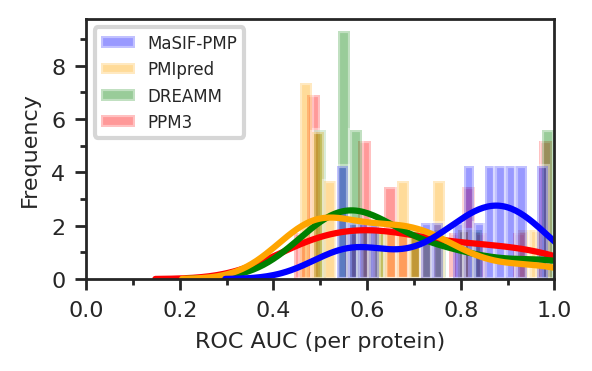

In [ ]:
## AUC comparison plot

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
sns.set(style="white", context="talk")

model_list = ['masif-pmp', 'pmipred', 'dreamm', 'ppm']
colors = ['blue', 'orange', 'green', 'red']

def model_name(model):
    if model == 'masif-pmp':
        return 'MaSIF-PMP'
    elif model == 'pmipred':
        return 'PMIpred'
    elif model == 'dreamm':
        return 'DREAMM'
    elif model == 'ppm':
        return 'PPM3'
    else:
        return model

f, ax1 = plt.subplots(1, 1, figsize=(3.3, 2.2), sharex=False)

# actual plotting
for model, color in zip(model_list[::-1], colors[::-1]):
    # Path to score files
    file_path = f'{root_dir}/score_auc_{model}.txt'
    auc_df = read_auc_scores(file_path)
    sns.distplot(auc_df["auc_surf_points"], bins=20, color=color, label=model_name(model), hist=True)
    # sns.histplot(auc_df["auc_surf_points"], bins=20, color=color, label=model_name(model), ax=ax1, kde=True)

ax1.set_xlim(0, 1)
ax1.set_xlabel("ROC AUC (per protein)", fontsize=8)
ax1.set_ylabel("Frequency",fontsize=8)

# Add ticks
ax1.xaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(axis='both', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='both', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
ax1.spines['top'].set_linewidth(1.0)
ax1.spines['bottom'].set_linewidth(1.0)
ax1.spines['right'].set_linewidth(1.0)
ax1.spines['left'].set_linewidth(1.0)

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]  # 0: ppm, 1: dreamm, 2: pmipred, 3: masif-pmp
# ax1.legend(fontsize=6)
ax1.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    fontsize=6
    )
plt.tight_layout()
plt.show()

/tmp/ipykernel_26850/2665521508.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_df["auc_per_residues"], bins=20, color=color, label=model_name(model), hist=True)
/tmp/ipykernel_26850/2665521508.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_df["auc_per_residues"], bins=20, col

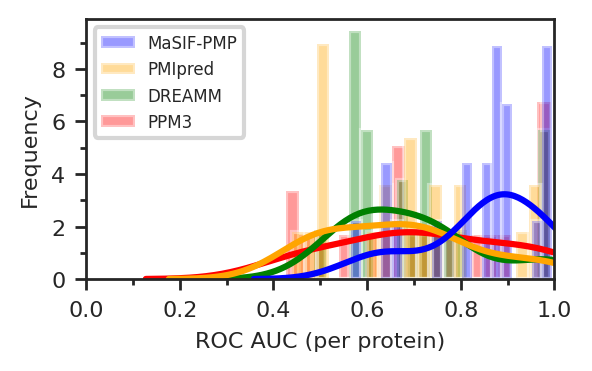

In [ ]:
## AUC comparison plot

import matplotlib.pyplot as plt
import seaborn as sns

model_list = ['masif-pmp', 'pmipred', 'dreamm', 'ppm']
colors = ['blue', 'orange', 'green', 'red']

f, ax1 = plt.subplots(1, 1, figsize=(3.3, 2.2), sharex=False)

# actual plotting
for model, color in zip(model_list[::-1], colors[::-1]):
    # Path to score files
    file_path = f'{root_dir}/score_auc_{model}.txt'
    auc_df = read_auc_scores(file_path)
    sns.distplot(auc_df["auc_per_residues"], bins=20, color=color, label=model_name(model), hist=True)


ax1.set_xlim(0, 1)
ax1.set_xlabel("ROC AUC (per protein)", fontsize=8)
ax1.set_ylabel("Frequency",fontsize=8)
# Add ticks
ax1.xaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(axis='both', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='both', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
ax1.spines['top'].set_linewidth(1.0)
ax1.spines['bottom'].set_linewidth(1.0)
ax1.spines['right'].set_linewidth(1.0)
ax1.spines['left'].set_linewidth(1.0)

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]  # 0: ppm, 1: dreamm, 2: pmipred, 3: masif-pmp
# ax1.legend(fontsize=6)
ax1.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    fontsize=6
    )
plt.tight_layout()
plt.show()

/tmp/ipykernel_26850/736824952.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mcc_df["mcc_surf_points"], bins=10, color=color, label=model_name(model), hist=True)
/tmp/ipykernel_26850/736824952.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mcc_df["mcc_surf_points"], bins=10, color=c

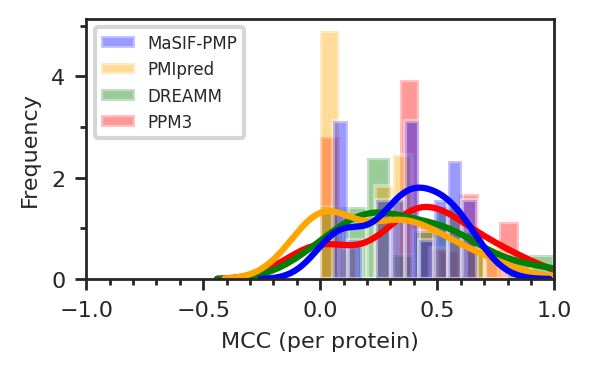

In [ ]:
## MCC comparison plot

import matplotlib.pyplot as plt
import seaborn as sns

model_list = ['masif-pmp', 'pmipred', 'dreamm', 'ppm']
colors = ['blue', 'orange', 'green', 'red']

f, ax1 = plt.subplots(1, 1, figsize=(3.3, 2.2), sharex=False)

# actual plotting
for model, color in zip(model_list[::-1], colors[::-1]):
    # Path to score files
    file_path = f'{root_dir}/score_mcc_{model}.txt'
    mcc_df = read_mcc_scores(file_path)
    sns.distplot(mcc_df["mcc_surf_points"], bins=10, color=color, label=model_name(model), hist=True)

ax1.set_xlim(-1, 1)
ax1.set_xlabel("MCC (per protein)", fontsize=8)
ax1.set_ylabel("Frequency",fontsize=8)
# Add ticks
ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(axis='both', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='both', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
ax1.spines['top'].set_linewidth(1.0)
ax1.spines['bottom'].set_linewidth(1.0)
ax1.spines['right'].set_linewidth(1.0)
ax1.spines['left'].set_linewidth(1.0)

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]  # 0: ppm, 1: dreamm, 2: pmipred, 3: masif-pmp
# ax1.legend(fontsize=6)
ax1.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    fontsize=6
    )
plt.tight_layout()
plt.show()


/tmp/ipykernel_26850/1128618796.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mcc_df["mcc_per_residues"], bins=10, color=color, label=model_name(model), hist=True)
/tmp/ipykernel_26850/1128618796.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mcc_df["mcc_per_residues"], bins=10, col

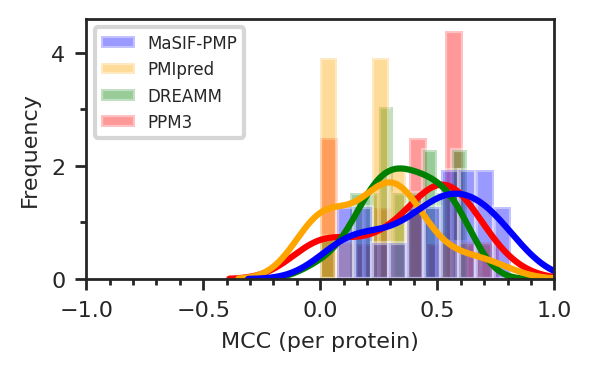

In [ ]:
## MCC comparison plot

import matplotlib.pyplot as plt
import seaborn as sns

model_list = ['masif-pmp', 'pmipred', 'dreamm', 'ppm']
colors = ['blue', 'orange', 'green', 'red']

f, ax1 = plt.subplots(1, 1, figsize=(3.3, 2.2), sharex=False)

# actual plotting
for model, color in zip(model_list[::-1], colors[::-1]):
    # Path to score files
    file_path = f'{root_dir}/score_mcc_{model}.txt'
    mcc_df = read_mcc_scores(file_path)
    sns.distplot(mcc_df["mcc_per_residues"], bins=10, color=color, label=model_name(model), hist=True)

ax1.set_xlim(-1, 1)
ax1.set_xlabel("MCC (per protein)", fontsize=8)
ax1.set_ylabel("Frequency",fontsize=8)
# Add ticks
ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(axis='both', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='both', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
ax1.spines['top'].set_linewidth(1.0)
ax1.spines['bottom'].set_linewidth(1.0)
ax1.spines['right'].set_linewidth(1.0)
ax1.spines['left'].set_linewidth(1.0)

handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0]  # 0: ppm, 1: dreamm, 2: pmipred, 3: masif-pmp
# ax1.legend(fontsize=6)
ax1.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    fontsize=6
    )
plt.tight_layout()
plt.show()

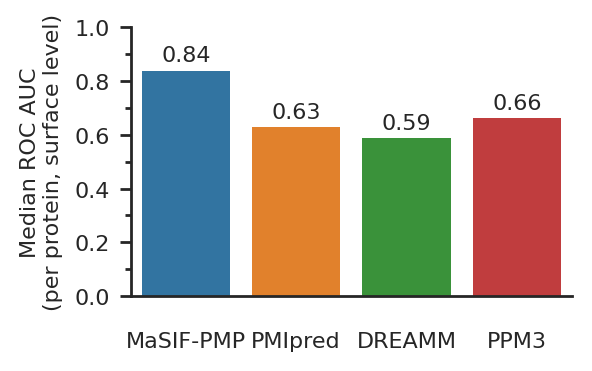

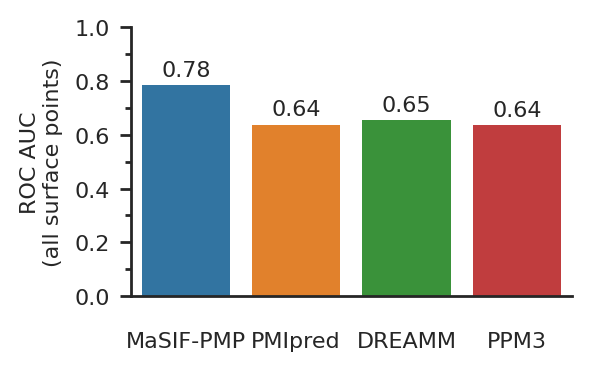

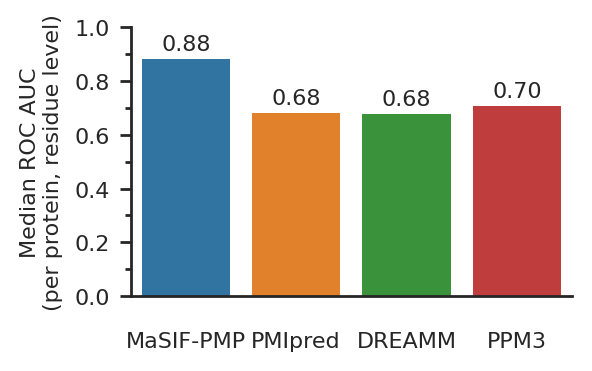

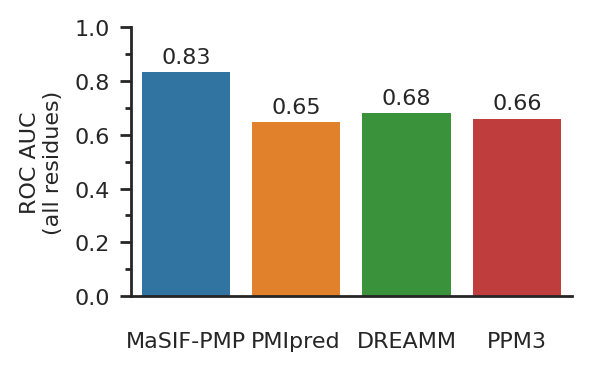

In [ ]:
import seaborn as sns
sns.set(style="white", context="talk", rc={"patch.edgecolor": "none"})

def barplots(xdata, ydata, ylabel='', save_path=None):
        f, (ax1) = plt.subplots(1, 1, figsize=(3.3, 2.2), sharex=False)

        plt.ylim([0.5,1.0])

        sns.barplot(x=xdata, y=ydata, ax=ax1, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])  # palette=['lightgray', 'blue', 'lightgreen', 'pink']
        ax1.set_xticklabels(xdata, fontsize=8)

        ax1.set_ylim([0,1])
        ax1.margins(y=0)

        for p, v in zip(ax1.patches, ydata):
            ax1.text(p.get_x() + p.get_width()/2, v + 0.02, f'{v:.2f}',
                     ha='center', va='bottom', fontsize=8)

        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        ax1.set_ylabel(ylabel, fontsize=8)
        # Add ticks
        ax1.yaxis.set_major_locator(MultipleLocator(0.2))
        ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax1.tick_params(axis='y', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
        ax1.tick_params(axis='y', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
        ax1.spines['bottom'].set_linewidth(1.0)
        ax1.spines['left'].set_linewidth(1.0)
        plt.tight_layout()

        if save_path != None:
            plt.savefig(save_path, format='eps', bbox_inches = 'tight', dpi=300)

## benchmark results
med_auc_per_ptn_per_res = [0.8796487603305785, 0.6795888035670052, 0.6764705882352942, 0.7049071618037136]
med_auc_per_ptn_per_pt = [0.8372467579451216, 0.6278196230264399, 0.5871559633027523, 0.6623334910298511]
auc_all_res = [0.832, 0.646, 0.680, 0.659]
auc_all_pt = [0.783, 0.637, 0.654, 0.636]

med_mcc_per_ptn_per_res = [0.5259547057403531, 0.2701740185374394, 0.3563483225498992, 0.4496951802798554]
med_mcc_per_ptn_per_pt = [0.37438128292172335, 0.2778509044351454, 0.27699437959480394, 0.4158238916489767]
mcc_all_res = [0.282, 0.268, 0.373, 0.401]
mcc_all_pt = [0.224, 0.303, 0.366, 0.386]


xdata = ['MaSIF-PMP', 'PMIpred', 'DREAMM', 'PPM3',]

## plots for ROC AUC
barplots(xdata, med_auc_per_ptn_per_pt, ylabel='Median ROC AUC\n(per protein, surface level)')
barplots(xdata, auc_all_pt, ylabel='ROC AUC\n(all surface points)')
barplots(xdata, med_auc_per_ptn_per_res, ylabel='Median ROC AUC\n(per protein, residue level)')
barplots(xdata, auc_all_res, ylabel='ROC AUC\n(all residues)')

plt.show()

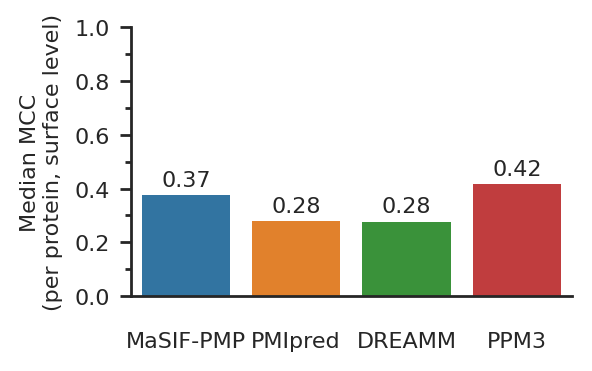

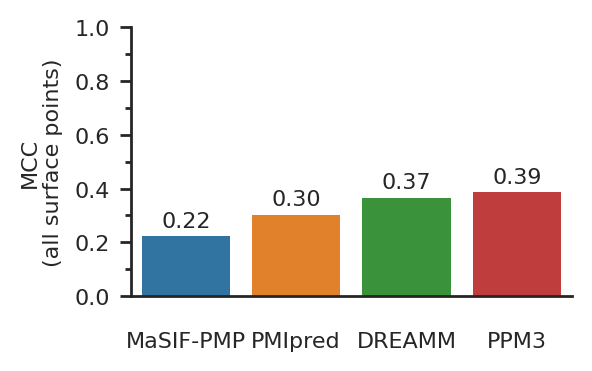

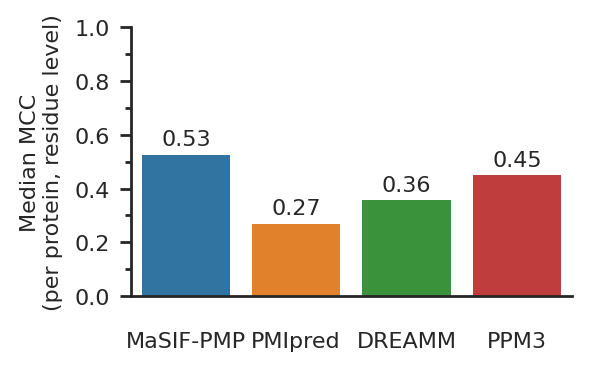

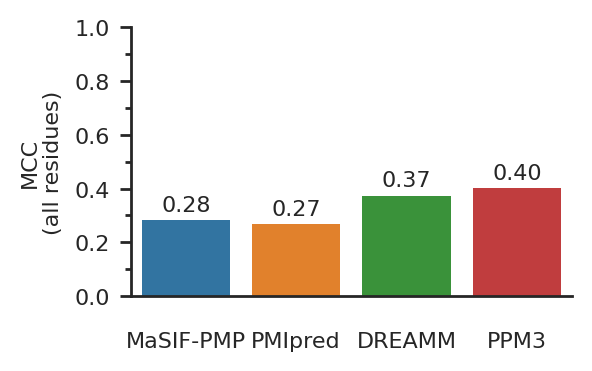

In [ ]:
## plots for MCC
barplots(xdata, med_mcc_per_ptn_per_pt, ylabel='Median MCC\n(per protein, surface level)')
barplots(xdata, mcc_all_pt, ylabel='MCC\n(all surface points)')
barplots(xdata, med_mcc_per_ptn_per_res, ylabel='Median MCC\n(per protein, residue level)')
barplots(xdata, mcc_all_res, ylabel='MCC\n(all residues)')

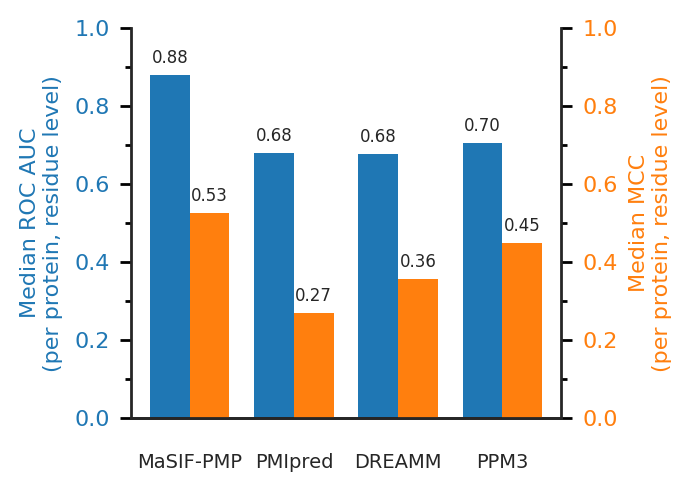

In [ ]:
## combined bar plots for benchmark results

sns.set(style="white", context="talk", rc={"patch.edgecolor": "none"})

def twin_barplot(xdata, y_auc, y_mcc,
                 ylabel_left='Median ROC AUC\n(per protein, residue level)',
                 ylabel_right='Median MCC\n(per protein, residue level)',
                 save_path=None):
    # fig, ax1 = plt.subplots(figsize=(3.8, 2.4))
    fig, ax1 = plt.subplots(figsize=(3.8, 2.8))
    ax2 = ax1.twinx()

    x = np.arange(len(xdata))
    width = 0.38

    # bars
    b1 = ax1.bar(x - width/2, y_auc, width=width, color='tab:blue', label='AUC', linewidth=0)
    b2 = ax2.bar(x + width/2, y_mcc, width=width, color='tab:orange', label='MCC', linewidth=0)

    # x / ticks
    ax1.set_xticks(x)
    ax1.set_xticklabels(xdata, fontsize=7, rotation=0, ha='center')

    # y scales & styling
    for a in (ax1, ax2):
        a.set_ylim(0, 1)
        a.margins(y=0)
        a.spines['top'].set_visible(False)
        a.tick_params(axis='y', labelsize=8, which='major', length=4, width=1, direction='out')
        a.tick_params(axis='y', labelsize=8, which='minor', length=2, width=1, direction='out')

    ax1.tick_params(axis='y', which='both', labelcolor='tab:blue', labelsize=8, color='black')
    ax2.tick_params(axis='y', which='both', labelcolor='tab:orange', labelsize=8, color='black')

    ax1.spines['bottom'].set_linewidth(1.0)
    ax1.spines['left'].set_linewidth(1.0)
    ax1.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_linewidth(1.0)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_linewidth(1.0)

    ax1.yaxis.set_major_locator(MultipleLocator(0.2))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax2.yaxis.set_major_locator(MultipleLocator(0.2))
    ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

    ax1.set_ylabel(ylabel_left, color='tab:blue', fontsize=8)
    ax2.set_ylabel(ylabel_right, color='tab:orange', fontsize=8)

    # annotate values
    def annotate(bars, vals, ax):
        for r, v in zip(bars, vals):
            ax.text(r.get_x() + r.get_width()/2, r.get_height() + 0.02,
                    f'{v:.2f}', ha='center', va='bottom', fontsize=6)
    annotate(b1, y_auc, ax1)
    annotate(b2, y_mcc, ax2)


    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, format='eps', bbox_inches='tight', dpi=300)
    return fig, (ax1, ax2)

# usage (residue-level example)
twin_barplot(xdata, med_auc_per_ptn_per_res, med_mcc_per_ptn_per_res,
             ylabel_left='Median ROC AUC\n(per protein, residue level)',
             ylabel_right='Median MCC\n(per protein, residue level)',)
plt.show()
